# GIN < FC

In [1]:
import numpy as np
import pickle
import pandas as pd 
import matplotlib.pyplot as plt
from importlib import reload

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch_geometric.data import Data, DataLoader

from torchinfo import summary
from sklearn.model_selection import StratifiedKFold

import sys
sys.path.append("..")
from brain_connectivity.trainer import Trainer
from brain_connectivity import dense as bc
from brain_connectivity.gin import GIN
from brain_connectivity.enums import ModelType, ConnectivityMode

## Load data

In [2]:
DATA_FOLDER = '../data'
PICKLE_FOLDER = '../pickles'

In [3]:
df_metadata = pd.read_csv(f'{DATA_FOLDER}/patients-cleaned.csv', index_col=0)
df_metadata.head(2)

,age,sex,target
0,24.750,1,0
1,27.667,1,0


### Select connectivity dataset

In [4]:
THRESHOLD = 0.05                                          # 0.01, 0.05, 0.1, 0.15
N = 20                                                   # 3, 5, 7, 10, 15, 20, 40
CORR_TYPE = 'pearson'                                    # 'pearson', 'spearman', 'partial-pearson'
THRESHOLD_METHOD = 'abs-group-avg-diff'                  # 'abs-sample-diff', 'abs-group-avg-diff'
THRESHOLD_TYPE = 'min'                                   # 'min', 'max' or for kNN 'small', 'large'
KNN = False                                              # Whether all or only top N neigbors are taken

In [5]:
fc_folder = f'{PICKLE_FOLDER}/fc-{CORR_TYPE}{"-knn" if KNN else ""}-{THRESHOLD_METHOD}'

# Try Gini or SGD.
# fc_folder = f'{PICKLE_FOLDER}/fc-{CORR_TYPE}-gini'
# fc_folder = f'{PICKLE_FOLDER}/fc-{CORR_TYPE}-sgd'

fc_file_binary = f'{fc_folder}/{THRESHOLD_TYPE}-{f"knn-{N}" if KNN else f"th-{THRESHOLD}"}-binary.pickle'
fc_file_real = f'{fc_folder}/{THRESHOLD_TYPE}-{f"knn-{N}" if KNN else f"th-{THRESHOLD}"}-real.pickle'

# fc_file_binary = f'{fc_folder}/binary.pickle'
# fc_file_real = f'{fc_folder}/real.pickle'

In [6]:
with open(f'{PICKLE_FOLDER}/fc-pearson.pickle', 'rb') as f:
    raw_matrix = pickle.load(f)

with open(fc_file_binary, 'rb') as f:
    edge_index_matrix = pickle.load(f)

with open(fc_file_real, 'rb') as f:
    fc_matrix = pickle.load(f)


num_samples, num_parcels, _ = edge_index_matrix.shape
edge_index_matrix.shape

(190, 90, 90)

## Split data

In [7]:
with open(f'{PICKLE_FOLDER}/test-indices.pickle', 'rb') as f:
    test_indices = pickle.load(f)
    
train_indices = list(set(range(num_samples)) - set(test_indices))
train_targets = df_metadata.iloc[train_indices]["target"].reset_index(drop=True)

print(f'Train set size: {len(train_indices)}')
print(f'Test set size: {len(test_indices)}')

Train set size: 140
Test set size: 50


## Prepare data

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### `Data` object fields

- `data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`

- `data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]` and type `torch.long`

- `data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`

- `data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

- `data.pos`: Node position matrix with shape `[num_nodes, num_dimensions]`

### Select node features

- onehot
- correlations

In [9]:
# Each nodes contains its row from FC matrix.
def correlations_in_nodes(i):
    return torch.from_numpy(fc_matrix[i]).to(torch.float32)


# Each brain region is onehot encoded. See GIN for phenotype paper.
def onehot_in_nodes(i):
    return torch.diag(torch.ones(num_parcels))

In [10]:
features_in_nodes = correlations_in_nodes
num_node_features = num_parcels
num_node_features

90

## Create datasets

### Graph dataset

In [11]:
graph_dataset = [Data(
    x=features_in_nodes(i),  
    edge_index=torch.from_numpy(np.asarray(np.nonzero(edge_index_matrix[i]))).to(torch.int64),
    # y=torch.tensor([[1, 0]]  if target == 0 else [[0, 1]], dtype=torch.int64)
    y=torch.tensor([target], dtype=torch.int64)
).to(device) for target, i in zip(train_targets, train_indices)]

In [12]:
print(f'True train data: {len(graph_dataset)}')

print('Data object')
print(f'Edge index: {graph_dataset[0].edge_index.shape}')
print(f'Node features: {graph_dataset[0].x.shape}')
print(f'Target: {graph_dataset[0].y.shape}')

True train data: 140
Data object
Edge index: torch.Size([2, 2622])
Node features: torch.Size([90, 90])
Target: torch.Size([1])


### Dense dataset

In [13]:
class dotdict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    

class DenseDataset(Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y
        

    def __getitem__(self, i):
        return {
            'x': self.x[i], 
            'y': self.y[i]
        }


    def __len__(self):
        return len(self.y)
    

In [14]:
dense_dataset = DenseDataset(
    torch.from_numpy(raw_matrix[train_indices]).to(torch.float32).to(device), 
    torch.from_numpy(train_targets.values).to(torch.int64).to(device)
)

## Define GIN & FC architectures

In [15]:
# Architecture FC.
summary(bc.ConnectivityDenseNet(
    num_parcels, 
    ConnectivityMode.SINGLE, 
    num_node_features,
    32,
    num_sublayers=3
))

Layer (type:depth-idx)                        Param #
ConnectivityDenseNet                          --
├─ConnectivityEmbedding: 1-1                  --
│    └─Dropout: 2-1                           --
├─ModuleList: 1-2                             --
│    └─ConnectivitySublayer: 2-2              --
│    │    └─ConnectivityEmbedding: 3-1        (recursive)
│    │    └─ConnectivityMLP: 3-2              2,912
│    └─ConnectivitySublayer: 2-3              --
│    │    └─ConnectivityEmbedding: 3-3        (recursive)
│    │    └─ConnectivityMLP: 3-4              1,056
│    └─ConnectivitySublayer: 2-4              --
│    │    └─ConnectivityEmbedding: 3-5        (recursive)
│    │    └─ConnectivityMLP: 3-6              1,056
├─Linear: 1-3                                 66
Total params: 5,090
Trainable params: 5,090
Non-trainable params: 0

In [16]:
# Architecture GIN.
summary(GIN(
    size_in=num_node_features,
    num_hidden_features=32,
    num_sublayers=3
))

Layer (type:depth-idx)                   Param #
GIN                                      --
├─ModuleList: 1-1                        --
│    └─GINConv: 2-1                      --
│    │    └─GinMLP: 3-1                  2,912
│    └─GINConv: 2-2                      --
│    │    └─GinMLP: 3-2                  1,056
│    └─GINConv: 2-3                      --
│    │    └─GinMLP: 3-3                  1,056
├─Linear: 1-2                            66
Total params: 5,090
Trainable params: 5,090
Non-trainable params: 0

## Train model

In [111]:
NUM_FOLDS = 3
skf = StratifiedKFold(n_splits=NUM_FOLDS, random_state=42, shuffle=True)

In [112]:
# Training parameters settings.
training_params = {
    # Training regime.
    'epochs': 200,
    'validation_frequency': 1,

    # Optimizer.
    'optimizer': torch.optim.Adam,
    'optimizer_kwargs': {
        # 'momentum': 0.5,
        'lr': 0.0005,
        'weight_decay': 0.0
    },

    # Scheduler.
    'step_size': 50,
    'gamma': 0.5,

    # Loss.
    'criterion': torch.nn.CrossEntropyLoss(),

    # Plotting.
    'fc_matrix_plot_frequency': 200,
    'fc_matrix_plot_sublayer': 0
}

In [113]:
# Model parameters settings.
model_params = {
    'size_in': num_node_features,
    'num_hidden_features': 90,
    'num_sublayers': 3,
    'dropout': 0.2
}

gin_params = {
    'eps': 0.2
}

dense_params = {
    'mode': ConnectivityMode.SINGLE,
    'num_nodes': num_parcels,
    'connectivity_dropout': 0.0,
    'readout': 'add'
}

In [114]:
# Experiment folder.
EXP_FOLDER = 'runs/fc-vs-gin'

# Experiment.
EXP_ID = 62

BATCH_SIZE = 8

MODEL_TYPE = ModelType.DENSE

In [115]:
reload(bc)

<module 'brain_connectivity.dense' from '..\\brain_connectivity\\dense.py'>

tensor(-116.8055, device='cuda:0', grad_fn=<SumBackward0>) -116.80553 -0.014420436 0.015398651


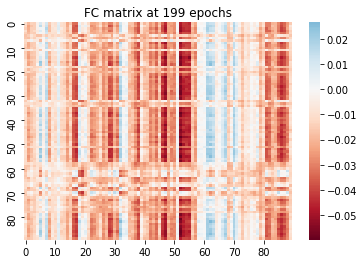

tensor(-97.8615, device='cuda:0', grad_fn=<SumBackward0>) -97.86148 -0.012081664 0.013552516


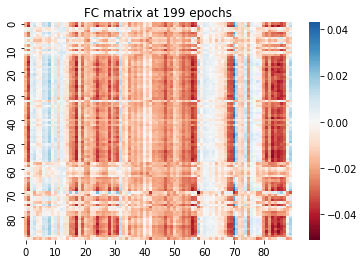

tensor(82.3886, device='cuda:0', grad_fn=<SumBackward0>) 82.38861 0.010171433 0.013093259


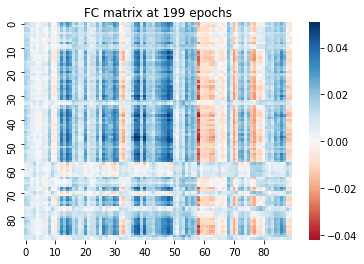

Finished training


In [116]:
for fold_id, (train_index, val_index) in enumerate(skf.split(np.zeros(len(train_targets)), train_targets)):

    # Init TB writer.
    experiment_str = f'id={EXP_ID:03d},fold={fold_id}'
    writer = SummaryWriter(f"../{EXP_FOLDER}/{MODEL_TYPE}/{experiment_str}")

    # Init model.
    if MODEL_TYPE == ModelType.GRAPH:
        net = GIN(**model_params, **gin_params).to(device)
    elif MODEL_TYPE == ModelType.DENSE:
        net = bc.ConnectivityDenseNet(**model_params, **dense_params).to(device)
    else:
        raise Exception('Unsupported model type.')

    # Prepare data.
    dataset = graph_dataset if MODEL_TYPE == ModelType.GRAPH else dense_dataset
    X_train = [dataset[i] for i in train_index]
    X_val = [dataset[i] for i in val_index]

    trainloader = DataLoader(X_train, batch_size=BATCH_SIZE, shuffle=True)
    valloader = DataLoader(X_val, batch_size=BATCH_SIZE, shuffle=False)
    if MODEL_TYPE == ModelType.DENSE:
        trainloader = list(map(dotdict, trainloader))
        valloader = list(map(dotdict, valloader))

    # Save architecture.
    with open(f"../{EXP_FOLDER}/{MODEL_TYPE}/{experiment_str}/architecture", 'w', encoding="utf-8") as f:
        if MODEL_TYPE == ModelType.GRAPH:
            f.write(fc_folder + '\n' + fc_file_binary + '\n' + fc_file_real + '\n')
        f.write(features_in_nodes.__str__() + '\n')
        f.write(training_params.__str__() + '\n')
        f.write(net.__str__() + '\n\n')
        f.write(str(summary(net)))

    # Init model wrapper.
    model = Trainer(
        model=net, 
        trainloader=trainloader, 
        valloader=valloader,
        writer=writer,
        **training_params
    )
    
    # Run training.
    model.train()


    # Single fold during exploration.
    # break

print('Finished training')